# Exercício 1 - Enunciado

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
- A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. 
  - o modo `Start` inicia o funcionamento com os valores iniciais das velocidades
  - no modo `Free`  não existe qualquer força de travagem; 
  - no modo `Stopping` aplica-se a força de travagem alta; 
  - no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  move-se (i.e. derrapa) com pequeno atrito ao solo; 
  - no modo `Stopped` o veículo está imobilizado.
- A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`   e a `velocidade linear das rodas`  ambas em relação so solo.
- Assume-se que o sistema de travagem exerce uma força de atrito proporcional à diferença das duas velocidades.  A dinâmica contínua, as equações de fluxo, está descrita  abaixo.
- Os “switchs” são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser  de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.
- É imprescindível evitar que o sistema tenha “trajetórias de Zenão”. Isto é, sequências  infinitas de transições  entre dois modos em intervalos de tempo  que tendem para zero mas nunca alcançam zero.

Faça 

1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
2. A condição de segurança estabelece que o sistema não permaneça no modo `free`  ou no modo `blocked` mais do que $\,\tau\,$ segundos.
3. Defina um SFOTS que modele a discretização do autómato híbrido.
4. Verifique nesse modelo
    1. Que as condições de segurança são invariantes do sistema
    2. Que o sistema atinge o estado `stopped` eventualmente.
    
Equações de Fluxo 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo a força de compressão é dada pelo o peso $P$ que é constante e independente do modo. Tem-se $f = a\, P$ sendo  $a$ a constante de atrito; o valor de $a$ depende do modo: é baixa em `Blocked` e alta nos restantes.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades
$$F =  c\, (V-v)$$
      A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.

4. As  equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,
$$(\dot{V} \,=\, -F)\,\land\, (\dot{v} \,=\, -a\, P  + F)$$
e , no modo `Blocked`,  a dinâmica do sistema é  regida por
                                                         $$(V = v) \;\land\; (\,\dot{v}\,=\, -a\, P\,)$$

6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que o controlo aí permaneça mais do que $\,\tau\,$segundos.  Os $\mathsf{switch}(V,v,t,V',v',t')\,$  nesses modos devem forçar esta condição. 
7. Todos os “switchs” devem ser construídos de  modo a impedir a existência de trajetórias de Zenão.
8. No instante inicial  o modo é  `Start` e  tem-se $\,V = v\,=\,V_0$  . A velocidade $V_0$ é  “input” do problema.

# Exercício 1 - Solução

In [2]:
from pysmt.shortcuts import *
from pysmt.typing import *
import matplotlib.pyplot as plt

import math

START = Int(-1)
FREE = Int(0)
STOPPING = Int(1)
BLOCKED = Int(2)
STOPPED = Int(3)

MODE = {-1: "START", 0: "FREE", 1: "STOPPING", 2: "BLOCKED", 3: "STOPPED"}

Suponhamos um carro típico com massa $1,300,000\,g$, o peso do sistema **Carro - Solo** será dado, pela formula usual para o Peso em solo plano:
$$P = mg \equiv P = 12,753,000\,N$$

Suponhamos agora que este carro está a deslocar-se num solo plano, nomeadamente numa estrada de cimento, onde, a uma velocidade de $50\, ms^{-1}$. <br>
Sabemos que a constante $\mu$ é, respetivamente, $\mu_s = 1$ e $\mu_k \approx 0.7$, no sistema **Cimento - Borracha**, para constante atrito estático e kinetico.

Pretendemos, agora, encontrar valores para constantes de proporcionalidade entre a Força de Travagem e a diferença de velocidades. Conforme o enunciado, esta será **alta** na fase stopping e **baixa** nas restantes. Na fase stopping, pretendemos **maximizar** o valor de c e, na fase free, pretendemos **minimizar** c tal que o valor de c seja consideravelmente próximo a zero, de tal forma a que este túplo (cB, cA), com os valores prévios, resultem no seguinte gráfico velocidade/tempo (canto superior direito).

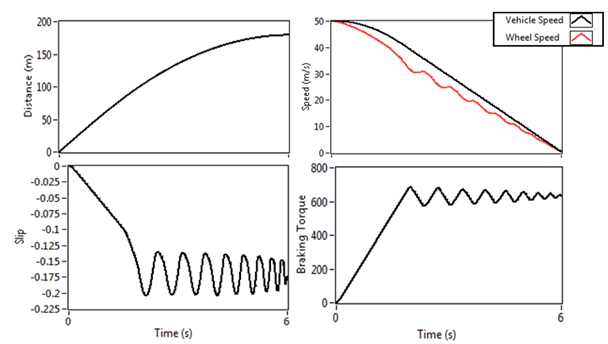

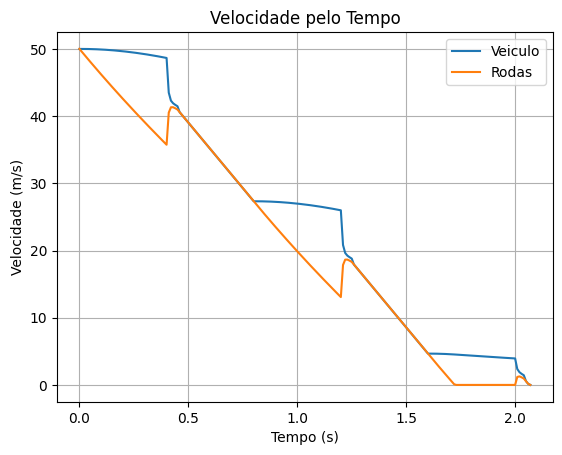

In [24]:
def simulation(aB, aA, cB, cA, dt, e, P, tau, vi):
    v = vi
    r = vi
    t = 0
    V = [v]
    R = [r]
    T = [t]
    timer = 0
    m = 0
    fk = aB * P
    fs = aA * P
    
    while((t<3) and (v>0 or r>0)):
        
        if m == 1 and (v - r < e )  :
            m = 2
        
        elif timer >= tau and m == 2:
            m = 0
            timer = 0
        
        elif timer >= tau and m == 0:
            m = 1
            timer = 0 
        
        if m == 0:
            v, r = v + (-cB*(v-r))*dt, r + (-fs + cB*(v-r))*dt
        elif m == 1:
            v, r = v + (-cA*(v-r))*dt, r + (-fs + cA*(v-r))*dt
        else:
            v, r = r + (-fk)*dt,     r + (-fk)*dt
        
        if v < 0:
            v = 0
        if r < 0:
            r = 0
        t += dt
        timer += dt
        V.append(v)
        R.append(r)
        T.append(t)
        
    plt.plot(T,V,T,R)
    plt.title("Velocidade pelo Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (m/s)")
    plt.legend(["Veiculo", "Rodas"], loc ="upper right")
    plt.grid(True)

aB = 0.001
aA = 0.03
cB = 0.5
cA = 40
dt = 0.01
e = 0.5
P = 1300
tau = 0.4
vi = 50
simulation(aA, aA, cB, cA, dt, e, P, tau, vi)


Tendo estes valores vamos definir um sistema que definirá as nossas variáveis *input*

$$
   \left\{\begin{array}{@{}l@{}}
   v_0 := 50\, ms^{-1}\\
   P  := 12,753,000\, N\\
   a^b := \mu_k\\
   a^a := \mu_s\\
   c^b := ---\\
   c^a := ---\\
   tau := 0.4\, s \\
   \text{diff\_velocity} := 0.5\, ms^{-1} \\
   \text{diff\_time}     := 0.01\, s \\
  \end{array}\right.\,
$$

In [23]:
V0 = 20.0
P = 1300
aA = 1.0
aB = 0.6
fs = P * aA
fk = P * aB
cA = 40.0
cB = 0.5
#Fs = cA * (V -v)
#Fo = cB * (V -v)
tau = 0.4
diff_velocity = 0.5
diff_time     = 0.01
diff_F        = 0.1

def decimal_range(start, stop, increment):
    while start < stop and not math.isclose(start, stop): # Py>3.5
        yield start
        start += increment

def inv(s):
    A = LE(s['tau'], Real(tau))
    B = Equals(s['m'], BLOCKED)
    C = Equals(s['m'], FREE)
    return Implies(Or(B, C), A)

def prop(s):
    return Equals(s['m'], STOPPED)

In [ ]:
def declare(i):
        s = {}
        s['t'] = Symbol('t'+str(i), REAL) # Time
        s['tau'] = Symbol('tau'+str(i), REAL) # Time in FREE and BLOCKED
        s['m'] = Symbol('m'+str(i), INT) # Mode
        s['V'] = Symbol('V'+str(i), REAL) # Velocity of body
        s['v'] = Symbol('v'+str(i), REAL) # Velocity of wheels
        return s

In [ ]:
def init(s, V0):
    return And(Equals(s['t'], Real(0)),
               Equals(s['tau'], Real(0)),
               Equals(s['m'], START),
               Equals(s['V'], Real(V0)),
               Equals(s['v'], Real(V0)),
              )

In [ ]:
def trans(s, p, P, aA, aB, cA, cB, tau, diff_velocity, diff_time):
    # Untimed
            
    # starting
    starting = And(Equals(s['m'], START),
                   Equals(p['m'], FREE),
                   Equals(p['tau'], Real(0)),
                   Equals(s['t'], p['t']),
                   Equals(s['V'], p['V']),
                   Equals(s['v'], p['v'])
                  )
        
    # breaking
    breaking = And(Equals(s['m'], FREE),
                   Equals(p['m'], STOPPING),
                   GE(s['tau'], Real(tau)),
                   Equals(s['t'], p['t']),
                   Equals(s['V'], p['V']),
                   Equals(s['v'], p['v']),
                   LE(Real(0), s['V']),
                   LE(Real(0), s['v'])
                  )        
        
    # blocking
    blocking = And(Equals(s['m'], STOPPING),
                   Equals(p['m'], BLOCKED),
                   Equals(p['tau'], Real(0)),
                   LT(Minus(s['V'], s['v']), Real(diff_velocity)),
                   Equals(s['V'], p['V']),
                   Equals(s['v'], p['v']),
                   LT(Real(0), s['V']),
                   LE(Real(0), s['v']),
                   Equals(s['t'], p['t'])
                  )
       
    # freeing
    freeing = And(Equals(s['m'], BLOCKED),
                  Equals(p['m'], FREE),
                  Equals(p['tau'], Real(0)),
                  GE(s['tau'], Real(tau)),
                  Equals(s['t'], p['t']),
                  Equals(s['V'], p['V']),
                  Equals(s['v'], p['v']),
                  LE(Real(0), s['V']),
                  LE(Real(0), s['v'])
                 )
    
    # ending
    ending = And(Equals(s['m'], STOPPING),
                 Equals(p['m'], STOPPED),
                 LT(s['V'], Real(diff_velocity)),
                 LT(s['v'], Real(diff_velocity)),
                 Equals(p['V'], Real(0)),
                 Equals(p['v'], Real(0)),
                 Equals(s['t'], p['t']),
                 Equals(s['tau'], p['tau'])
                )
    
    # stopped
    stopped = And(Equals(s['m'], STOPPED),
                  Equals(p['m'], STOPPED),
                  Equals(s['V'], p['V']),
                  Equals(s['v'], p['v']),
                  Equals(s['t'], p['t']),
                  Equals(s['tau'], p['tau'])
                 )
    
    untimed = Or(starting, breaking, blocking, freeing, ending, stopped)
    
    # Timed

    vals_diff = []
    vals_s_diff = []
    i = 0
    for i in decimal_range(0,fs * tau, 0.5):
        vals_diff.append(i)
    for i in decimal_range(0,fk * tau, 0.5):
        vals_s_diff.append(i)
    # free
    free = Or(And(Equals(s['m'], FREE),
                  Equals(p['m'], FREE),
                  GT(Minus(p['t'], s['t']), Real(diff_time)),
                  LE(Real(0), s['tau']),
                  Equals(p['tau'], Plus(s['tau'], Minus(p['t'], s['t']))),
                  LE(p['tau'], Real(tau)),
                  LE(Real(0), s['V']),
                  LE(Real(0), s['v']),
                  LE(Real(0), p['V']),
                  LE(Real(0), p['v']),
                  LT(Minus(s['V'], s['v']), Plus(Real(aprox), Real(0.5))),
                  GE(Minus(s['V'], s['v']), Minus(Real(aprox), Real(0.5))),
                  Equals(Minus(p['V'], s['V']),
                         Times(Times(Real(-cB), Real(aprox)), 
                               Minus(p['t'], s['t'])
                              )
                        ),
                  Equals(Minus(p['v'], s['v']),
                         Times(Plus(Times(Real(-aA), Real(P)), 
                                    Times(Real(cB), Real(aprox))
                                   ),
                               Minus(p['t'], s['t']))
                        )
                 )
              for aprox in vals_diff
             ) 
    
    # stopping
    stopping = Or(And(Equals(s['m'], STOPPING),
                      Equals(p['m'], STOPPING),
                      GT(Minus(p['t'], s['t']), Real(diff_time)),
                      Equals(s['tau'], p['tau']),
                      LE(Real(0), s['V']),
                      LE(Real(0), s['v']),
                      LE(Real(0), p['V']),
                      LE(Real(0), p['v']),
                      GE(Minus(s['V'], s['v']), Real(diff_velocity)),
                      GE(Minus(p['V'], p['v']), Real(0)),
                      LT(Minus(s['V'], s['v']), Plus(Real(aprox), Real(0.5))),
                      GE(Minus(s['V'], s['v']), Minus(Real(aprox), Real(0.5))),
                      Equals(Minus(p['V'], s['V']),
                         Times(Times(Real(-cA), Real(aprox)), 
                               Minus(p['t'], s['t'])
                              )
                        ),
                      Equals(Minus(p['v'], s['v']),
                             Times(Plus(Times(Real(-aA), Real(P)), 
                                        Times(Real(cA), Real(aprox))
                                       ),
                                   Minus(p['t'], s['t'])
                                  )
                            )
                     )
                  for aprox in vals_diff
                 )
    
    # blocked
    blocked = Or(And(Equals(s['m'], BLOCKED),
                     Equals(p['m'], BLOCKED),
                     GT(Minus(p['t'], s['t']), Real(diff_time)),
                     LE(Real(0), s['tau']),
                     LE(s['tau'], Real(tau)),
                     Equals(p['tau'], Plus(s['tau'], Minus(p['t'], s['t']))),
                     LE(p['tau'], Real(tau)),
                     LE(Real(0), s['V']),
                     LE(Real(0), s['v']),
                     LT(aprox, Real(diff_velocity)),
                     Equals(Minus(p['v'], s['v']), 
                            Times(Times(Real(-aB), Real(P)), 
                                  Minus(p['t'], s['t'])
                                 )
                           )
                    )
                 for aprox in aprox_s_val
                )
    
    timed = Or(free, stopping, blocked)
    
    return Or(untimed, timed)

In [ ]:
def print_vars(s, solver):
    for var in s:
        if s[var].get_type() == REAL:
            print(f"  {var} = {float(solver.get_py_value(s[var]))}")
        # if s[var].get_type() == INT:
        if var == "m":
            print(f"  {var} = {MODE[solver.get_py_value(s[var])]}")

def gera_traco(declare,init,trans,k, V0, P, aA, aB, cA, cB, tau, diff_velocity, diff_time):
    states = [declare(i) for i in range(k)]
    with Solver(name="z3") as solver:
        solver.add_assertion(init(states[0], V0))
        for i in range(k-1):
            solver.add_assertion(trans(states[i], states[i+1], P, aA, aB, cA, cB, tau, diff_velocity, diff_time))
        
        if solver.solve():
            for i,s in enumerate(states):
                print(f"> State {i}:")
                print_vars(s, solver)
        else:
            print("> Not feasible.")

def gera_traco_parou(declare,init,trans,k, V0, P, aA, aB, cA, cB, tau, diff_velocity, diff_time):
    states = [declare(i) for i in range(k)]
    with Solver(name="z3") as solver:
        solver.add_assertion(init(states[0], V0))
        solver.add_assertion(Not(Equals(states[-2]['m'], STOPPED)))
        solver.add_assertion(Equals(states[-1]['m'], STOPPED))
        for i in range(k-1):
            solver.add_assertion(trans(states[i], states[i+1], P, aA, aB, cA, cB, tau, diff_velocity, diff_time))
        
        if solver.solve():
            for i,s in enumerate(states):
                print(f"> State {i}:")
                print_vars(s, solver)
        else:
            print("> Not feasible.")

def kinduction_always(declare,init,trans,inv,k, V0, P, aA, aB, cA, cB, tau, diff_velocity, diff_time):
    with Solver(name="z3") as solver:
        s = [declare(i) for i in range(k)]
        solver.add_assertion(init(s[0], V0))
        for i in range(k-1):
            solver.add_assertion(trans(s[i], s[i+1], P, aA, aB, cA, cB, tau, diff_velocity, diff_time))
            
        for i in range(k-1):
            solver.push()
            solver.add_assertion(Not(inv(s[i])))
            if solver.solve():
                print(f"> Contradição! O invariante não se verifica nos k estados iniciais.")
                for i,s3 in enumerate(s):
                    print_vars(s3, solver)
                    print("--------------")
                return
            solver.pop()
        
        s2 = [declare(i+k) for i in range(k+1)]
        
        for i in range(k):
            solver.add_assertion(inv(s2[i]))
            solver.add_assertion(trans(s2[i], s2[i+1], P, aA, aB, cA, cB, tau, diff_velocity, diff_time))
        
        solver.add_assertion(Not(inv(s2[-1])))
        
        if solver.solve():
            print(f"> Contradição! O passo indutivo não se verifica.")
            for i,s4 in enumerate(s2):
                print_vars(s4, solver)
            return
        
        print(f"> A propriedade verifica-se por k-indução (k={k}).")


def bmc_eventually1(declare, init, trans, prop, bound, V0, P, aA, aB, cA, cB, tau, diff_velocity, diff_time):
    for k in range(1,bound+1):
         with Solver(name="z3") as solver:
            s = [declare(i) for i in range(k)]
    
            solver.add_assertion(init(s[0], V0))
            for i in range(k-1):
                solver.add_assertion(trans(s[i], s[i+1], P, aA, aB, cA, cB, tau, diff_velocity, diff_time))
            
            for i in range(k):
                solver.add_assertion(Not(prop(s[i])))
            
            solver.add_assertion(Or(trans(s[k-1],s[i],P, aA, aB, cA, cB, tau, diff_velocity, diff_time) for i in range(k)))
            
            if solver.solve():
                print_vars(s,solver)
                return
            
    print("A propriedade é válida para traços de tamanho até " + str(k))

In [ ]:
gera_traco_parou(declare, init, trans, 20, V0, P, aA, aB, cA, cB, tau, diff_velocity, diff_time)

In [ ]:
kinduction_always(declare, init, trans, inv, 5, V0, P, aA, aB, cA, cB, tau, diff_velocity, diff_time)


In [ ]:
bmc_eventually1(declare, init, trans, inv, 5, V0, P, aA, aB, cA, cB, tau, diff_velocity, diff_time)

In [ ]:
40.8 * 2 * 20